In [ ]:
!nvidia-smi

Tue Feb 16 12:54:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    60W / 149W |    263MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Experiment 2
<font size=5>We'll use an encoder-decoder architecture which is good for seq2seq models. Some portion of our sequences will be used for encoder input and rest for decoder inputs.</font>

We'll first use teacher forcing for training.

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Thesis/Attack\ Step\ Prediction/Implementation
!ls

/content/drive/MyDrive/Thesis/Attack Step Prediction/Implementation
APTGen_json	 __pycache__  s2s_stacked    test_data_sequence.txt
aptgen_utils.py  s2s_normal   sequences.csv  unique_steps.txt


In [ ]:
import tensorflow as tf
import numpy as np
import random
import csv

import aptgen_utils

In [ ]:
# to reflect the changes, the module needs to be reloaded
import importlib
importlib.reload(aptgen_utils)

<module 'aptgen_utils' from '/content/drive/MyDrive/Thesis/Attack Step Prediction/Implementation/aptgen_utils.py'>

# Data Preprocessing

In [ ]:
# get attack sequences as list of lists
data_text = aptgen_utils.get_data_text()
print(data_text[0])
len(data_text)

['collection TA0009 Email_Collection T1114', 'credential_access TA0006 Credential_Dumping T1003', 'discovery TA0007 System_Information_Discovery T1082', 'collection TA0009 Email_Collection T1114', 'defense_evasion TA0005 File_Deletion T1107', 'persistence TA0003 Scheduled_Task T1053', 'discovery TA0007 System_Information_Discovery T1082', 'collection TA0009 Email_Collection T1114']


800

We'll strip all spaces so that `Tokenizer()` can build *word_index* later.

In [ ]:
# strip all spaces from data_text
data_text = [[''.join(''.join(step).split()) for step in data] for data in data_text]
print(data_text[0])
len(data_text)

['collectionTA0009Email_CollectionT1114', 'credential_accessTA0006Credential_DumpingT1003', 'discoveryTA0007System_Information_DiscoveryT1082', 'collectionTA0009Email_CollectionT1114', 'defense_evasionTA0005File_DeletionT1107', 'persistenceTA0003Scheduled_TaskT1053', 'discoveryTA0007System_Information_DiscoveryT1082', 'collectionTA0009Email_CollectionT1114']


800

Now, let's find the frequency of different sequence length to determine how much timestep of input should go to the encoder and decoder.

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 5, 6, 6, 8, 12, 12, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 18, 18, 7, 7, 7, 8, 8, 9, 9, 9, 9, 9, 10, 11, 11, 12, 12, 12, 12, 12, 13, 13, 6, 8, 9, 10, 13, 17, 18, 19, 19, 21, 21, 21, 22, 23, 24, 25, 25, 25, 25, 26, 16, 16, 17, 19, 19, 22, 22, 22, 24, 26, 27, 27, 28, 29, 29, 30, 31, 32, 34, 35, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 12, 12, 12, 12, 12, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 18, 18, 18, 20, 6, 6, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 12, 13, 14, 14, 16, 18, 21, 4, 6, 7, 8, 11, 13, 15, 17, 17, 18, 18, 19, 20, 22, 22, 24, 25, 25, 25, 25, 13, 14, 16, 17, 17, 18, 20, 20, 24, 25, 25, 26, 26, 26, 27, 27, 28, 28, 29, 30, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 6, 7, 7, 9, 11, 12, 12, 13, 13, 13, 14, 14, 14, 15, 16, 16, 18, 18, 19, 9, 9, 11, 12, 12, 13, 13, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 18, 14, 14, 15, 16, 17, 18, 18, 19, 19, 20, 20, 21, 21, 21, 22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


<StemContainer object of 3 artists>

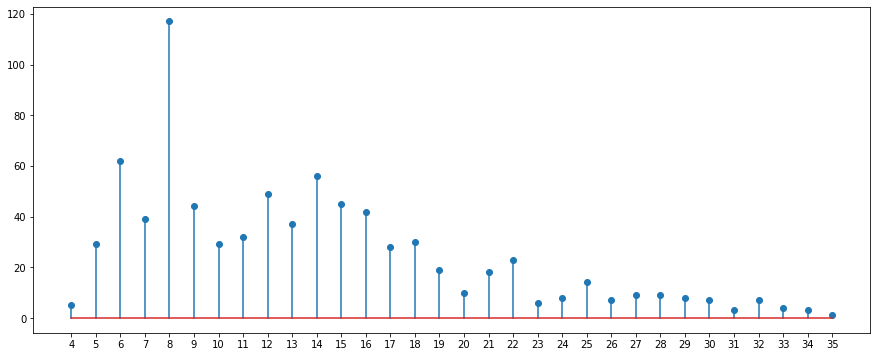

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# get length of different sequences in a list
sequence_lengths = [len(sequence) for sequence in data_text]
print(sequence_lengths)

counter = Counter(sequence_lengths)
print("Frequncy of sequence lengths:", counter)
print("Number of unique sequence lengths:", len(counter.keys()))

plt.figure(figsize=(15, 6))
x = [key for key in counter.keys()]
y = [val for val in counter.values()]

plt.xticks(x)
plt.stem(x, y)

In [ ]:
counter

Counter({4: 5,
         5: 29,
         6: 62,
         7: 39,
         8: 117,
         9: 44,
         10: 29,
         11: 32,
         12: 49,
         13: 37,
         14: 56,
         15: 45,
         16: 42,
         17: 28,
         18: 30,
         19: 19,
         20: 10,
         21: 18,
         22: 23,
         23: 6,
         24: 8,
         25: 14,
         26: 7,
         27: 9,
         28: 9,
         29: 8,
         30: 7,
         31: 3,
         32: 7,
         33: 4,
         34: 3,
         35: 1})

As the shortest length(4) occurs only 4 times and long lengths(33, 34, 35) occur respectively 4, 3 & 1 times only, so we'll not consider those sequences in our experiment.

In [ ]:
def remove_sequence(data_text, lengths_to_remove):
    lengths_to_remove = lengths_to_remove
    truncated_data_text = [sequence for sequence in data_text if len(sequence) not in lengths_to_remove]
    print("First sequence after truncating:", truncated_data_text[0])
    print("Number of sequence after truncating:", len(truncated_data_text))

    return truncated_data_text

In [ ]:
# remove sequences having length 4, 33, 34, 35
lengths_to_remove = [4, 33, 34, 35]
truncated_data_text = remove_sequence(data_text, lengths_to_remove)

First sequence after truncating: ['collectionTA0009Email_CollectionT1114', 'credential_accessTA0006Credential_DumpingT1003', 'discoveryTA0007System_Information_DiscoveryT1082', 'collectionTA0009Email_CollectionT1114', 'defense_evasionTA0005File_DeletionT1107', 'persistenceTA0003Scheduled_TaskT1053', 'discoveryTA0007System_Information_DiscoveryT1082', 'collectionTA0009Email_CollectionT1114']
Number of sequence after truncating: 787


At first, we'll take `4` steps as the *encoder_input* and remaining steps as *decoder_input*. We'll add `<sos>` as the start symbol before all decoder_input. *decoder_target* will be same as decoder_input except they will be shifted one timestep left. We'll add `<eos>` to the right of every decoder_target sequence.

In [ ]:
# split data into encoder and decoder text
def split_encoder_decoder_text(truncated_data_text, split):
    split = split
    encoder_input_text, decoder_input_text, decoder_target_text = [], [], []

    for sequence in truncated_data_text:
        encoder_input_text.append(sequence[:split])
        decoder_input_text.append(["<sos>"] + sequence[split:]) # add <sos> in the beginning of each sequence
        decoder_target_text.append(sequence[split:] + ["<eos>"]) # add <eos> at the end of each sequence
    
    print("encoder_input_text[0]:", encoder_input_text[0], "\ndecoder_input_text[0]:", decoder_input_text[0], "\ndecoder_target_text[0]:", decoder_target_text[0], "\n")
    print("encoder_input_text[69]:", encoder_input_text[69], "\ndecoder_input_text[69]:", decoder_input_text[69], "\ndecoder_target_text[69]:", decoder_target_text[69], "\n")
    print("encoder_input_text[169]:", encoder_input_text[169], "\ndecoder_input_text[169]:", decoder_input_text[169], "\ndecoder_target_text[169]:", decoder_target_text[169], "\n")
    print("encoder_input_text[650]:", encoder_input_text[650], "\ndecoder_input_text[650]:", decoder_input_text[650], "\ndecoder_target_text[650]:", decoder_target_text[650], "\n")

    return encoder_input_text, decoder_input_text, decoder_target_text

In [ ]:
# split each sequence at 4th step
split = 4
encoder_input_text, decoder_input_text, decoder_target_text = split_encoder_decoder_text(truncated_data_text, split)
print("Number of samples:", len(encoder_input_text))

encoder_input_text[0]: ['collectionTA0009Email_CollectionT1114', 'credential_accessTA0006Credential_DumpingT1003', 'discoveryTA0007System_Information_DiscoveryT1082', 'collectionTA0009Email_CollectionT1114'] 
decoder_input_text[0]: ['<sos>', 'defense_evasionTA0005File_DeletionT1107', 'persistenceTA0003Scheduled_TaskT1053', 'discoveryTA0007System_Information_DiscoveryT1082', 'collectionTA0009Email_CollectionT1114'] 
decoder_target_text[0]: ['defense_evasionTA0005File_DeletionT1107', 'persistenceTA0003Scheduled_TaskT1053', 'discoveryTA0007System_Information_DiscoveryT1082', 'collectionTA0009Email_CollectionT1114', '<eos>'] 

encoder_input_text[69]: ['discoveryTA0007System_Network_Configuration_DiscoveryT1016', 'collectionTA0009Data_StagedT1074', 'persistenceTA0003Scheduled_TaskT1053', 'credential_accessTA0006Credentials_in_RegistryT1214'] 
decoder_input_text[69]: ['<sos>', 'exfiltrationTA0010Exfiltration_Over_Command_and_Control_ChannelT1041', 'collectionTA0009Data_StagedT1074', 'collect

# Text sequences to integer sequences

Now that we've set the encoder and decoder text, lets build the word2idx and idx2word dictionary mapping which will later be used for conversion purpose. We'll also convert the text sequences to integer sequences as deep learning framework can only handle numbers.

We'll use the `Tokenizer()` class for above purpose.

In [ ]:
import copy
from keras.preprocessing.text import Tokenizer

def get_tokenizer(text):
    tokenizer = Tokenizer(num_words=200, lower=False) # we just give a large enough arbitrary number
    tokenizer.fit_on_texts(text)
    
    # builid word2idx and idx2word dictionary
    word2idx = copy.deepcopy(tokenizer.word_index)
    idx2word = {v:k for k, v in tokenizer.word_index.items()}

    return tokenizer, word2idx, idx2word

In [ ]:
def get_encoder_decoder_indices(encoder_input_text, decoder_input_text, decoder_target_text):
    encoder_tokenizer, encoder_word2idx, encoder_idx2word = get_tokenizer(encoder_input_text)
    print("encoder_word2idx:", encoder_word2idx)
    print("encoder_idx2word:", encoder_idx2word)
    encoder_input_indices = encoder_tokenizer.texts_to_sequences(encoder_input_text)


    decoder_tokenizer, decoder_word2idx, decoder_idx2word = get_tokenizer(decoder_input_text + decoder_target_text)
    print("\ndecoder_word2idx:", decoder_word2idx)
    print("decoder_idx2word:", decoder_idx2word)
    decoder_input_indices = decoder_tokenizer.texts_to_sequences(decoder_input_text)
    decoder_target_indices = decoder_tokenizer.texts_to_sequences(decoder_target_text)

    print("\nencoder_input_indices[0]:", encoder_input_indices[0], "\ndecoder_input_indices[0]:", decoder_input_indices[0], "\ndecoder_target_indices[0]:", decoder_target_indices[0], "\n")
    print("encoder_input_indices[69]:", encoder_input_indices[69], "\ndecoder_input_indices[69]:", decoder_input_indices[69], "\ndecoder_target_indices[69]:", decoder_target_indices[69], "\n")
    print("encoder_input_indices[169]:", encoder_input_indices[169], "\ndecoder_input_indices[169]:", decoder_input_indices[169], "\ndecoder_target_indices[169]:", decoder_target_indices[169], "\n")
    print("encoder_input_indices[650]:", encoder_input_indices[650], "\ndecoder_input_indices[650]:", decoder_input_indices[650], "\ndecoder_target_indices[650]:", decoder_target_indices[650], "\n")

    return encoder_input_indices, decoder_input_indices, decoder_target_indices, encoder_word2idx, encoder_idx2word, decoder_word2idx, decoder_idx2word

In [ ]:
# get input_indices and word conversion dicts
encoder_input_indices, decoder_input_indices, decoder_target_indices, encoder_word2idx, encoder_idx2word, decoder_word2idx, decoder_idx2word \
= \
get_encoder_decoder_indices(encoder_input_text, decoder_input_text, decoder_target_text)

encoder_word2idx: {'credential_accessTA0006Credential_DumpingT1003': 1, 'discoveryTA0007File_and_Directory_DiscoveryT1083': 2, 'discoveryTA0007Remote_System_DiscoveryT1018': 3, 'defense_evasionTA0005Deobfuscate/Decode_Files_or_InformationT1140': 4, 'collectionTA0009Input_CaptureT1056': 5, 'defense_evasionTA0005File_DeletionT1107': 6, 'collectionTA0009Data_StagedT1074': 7, 'credential_accessTA0006Input_CaptureT1056': 8, 'collectionTA0009Email_CollectionT1114': 9, 'persistenceTA0003Scheduled_TaskT1053': 10, 'persistenceTA0003New_ServiceT1050': 11, 'defense_evasionTA0005Indicator_Removal_on_HostT1070': 12, 'credential_accessTA0006Credentials_in_FilesT1081': 13, 'discoveryTA0007System_Time_DiscoveryT1124': 14, 'credential_accessTA0006Credentials_in_RegistryT1214': 15, 'discoveryTA0007Account_DiscoveryT1087': 16, 'lateral_movementTA0008Remote_File_CopyT1105': 17, 'discoveryTA0007System_Network_Configuration_DiscoveryT1016': 18, 'persistenceTA0003Logon_ScriptsT1037': 19, 'discoveryTA0007Quer

# Padding, Split & One-hot 🔥

Encoder inputs all have the same length so we dont need any padding there. But decoder inputs are of variable length and we need padding.

Lets find out the maximum sequence length in both encoder and decoder inputs.

Note: <font color="yellow">decoder_input and decoder_target both have same sequence length.</font>

In [ ]:
max_encoder_seq_length = max([len(sequence) for sequence in encoder_input_indices])
max_decoder_seq_length = max([len(sequence) for sequence in decoder_input_indices])

print("Max sequence length for encoder:", max_encoder_seq_length)
print("Max sequence length for decoder:", max_decoder_seq_length)

Max sequence length for encoder: 4
Max sequence length for decoder: 29


In [ ]:
from keras.preprocessing.sequence import pad_sequences

def get_padded_inputs(encoder_input_indices, decoder_input_indices, decoder_target_indices):
    
    padded_decoder_input = pad_sequences(decoder_input_indices, maxlen=max_decoder_seq_length, dtype='int32', padding='post')
    padded_decoder_target = pad_sequences(decoder_target_indices, maxlen=max_decoder_seq_length, dtype='int32', padding='post')
    print("\npadded_decoder_input[0]", padded_decoder_input[0])
    print("padded_decoder_target[0]", padded_decoder_target[0])
    print("padded_decoder_input[69]", padded_decoder_input[69])
    print("padded_decoder_target[69", padded_decoder_target[69])

    return padded_decoder_input, padded_decoder_target

In [ ]:
padded_decoder_input, padded_decoder_target = get_padded_inputs(encoder_input_indices, decoder_input_indices, decoder_target_indices)


padded_decoder_input[0] [ 8  4 22 26 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
padded_decoder_target[0] [ 4 22 26 12  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
padded_decoder_input[69] [ 8  3  1 12  3  4  6  4 18 21 12 18  1  4  5 26  7  4  0  0  0  0  0  0
  0  0  0  0  0]
padded_decoder_target[69 [ 3  1 12  3  4  6  4 18 21 12 18  1  4  5 26  7  4  9  0  0  0  0  0  0
  0  0  0  0  0]


Before further processing, lets divide our data into train and test set. we'll randomly take 750 sequences as training data and rest as testing.

In [ ]:
def get_train_test_data(num_train_sample, encoder_input_indices, padded_decoder_input, padded_decoder_target):
    num_total_sample = len(encoder_input_indices)
    random.seed(69)
    random_indices = list(range(num_total_sample))
    random.shuffle(random_indices)
    # print(random_indices)
    encoder_train_input = [encoder_input_indices[i] for i in random_indices[:num_train_sample]]
    decoder_train_input = [padded_decoder_input[i] for i in random_indices[:num_train_sample]]
    decoder_train_target = [padded_decoder_target[i] for i in random_indices[:num_train_sample]]

    encoder_test_input = [encoder_input_indices[i] for i in random_indices[num_train_sample:]]
    decoder_test_input = [padded_decoder_input[i] for i in random_indices[num_train_sample:]]
    decoder_test_target = [padded_decoder_target[i] for i in random_indices[num_train_sample:]]

    print("Number of training samples:", len(encoder_train_input))
    print("Number of testing samples:", len(encoder_test_input))

    print("\nencoder_train_input[0]:", encoder_train_input[0], "\ndecoder_train_input[0]:", decoder_train_input[0], "\ndecoder_train_target[0]:", decoder_train_target[0], "\n")
    print("encoder_train_input[69]:", encoder_train_input[69], "\ndecoder_train_input[69]:", decoder_train_input[69], "\ndecoder_train_target[69]:", decoder_train_target[69], "\n")
    print("encoder_test_input[0]:", encoder_test_input[0], "\ndecoder_test_input[0]:", decoder_test_input[0], "\ndecoder_test_target[0]:", decoder_test_target[0], "\n")
    print("encoder_test_input[15]:", encoder_test_input[15], "\ndecoder_test_input[15]:", decoder_test_input[15], "\ndecoder_test_target[15]:", decoder_test_target[15], "\n")

    return encoder_train_input, decoder_train_input, decoder_train_target, encoder_test_input, decoder_test_input, decoder_test_target

In [ ]:
# split the data into train and test set
num_train_sample = 750
encoder_train_input, decoder_train_input, decoder_train_target, encoder_test_input, decoder_test_input, decoder_test_target \
= \
get_train_test_data(num_train_sample, encoder_input_indices, padded_decoder_input, padded_decoder_target)

Number of training samples: 750
Number of testing samples: 37

encoder_train_input[0]: [9, 7, 7, 30] 
decoder_train_input[0]: [ 8 26  2  5  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0] 
decoder_train_target[0]: [26  2  5  4  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0] 

encoder_train_input[69]: [2, 40, 10, 3] 
decoder_train_input[69]: [ 8  1 31 31 39  1  6  3 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0] 
decoder_train_target[69]: [ 1 31 31 39  1  6  3 13  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0] 

encoder_test_input[0]: [7, 45, 22, 30] 
decoder_test_input[0]: [ 8 41  6 10 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0] 
decoder_test_target[0]: [41  6 10 40  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0] 

encoder_test_input[15]: [19, 4, 4, 13] 
decoder_test_input[15]: [8 5 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Now, we'll find the number of unique tokens in the encoder and decoder input text. This will determine the <font size=5> *vocab_size* </font> and <font size=5>*dimension of one-hot encoding*</font>.

The *max value* from the word2idx dict is basically the number of unique tokens.

In [ ]:
num_encoder_tokens = max(encoder_word2idx.values())
num_decoder_tokens = max(decoder_word2idx.values())

print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)

Number of unique input tokens: 50
Number of unique output tokens: 52


Now that our data preprocessing is almost finished, lets give the final touch by converting all the encoder and decoder inputs to <font size=5>*onehot vectors*</font>. For now, we'll only convert the training samples.

In [ ]:
def convert_to_onehot(encoder_train_input, decoder_train_input, decoder_train_target):    
    encoder_train_input_oh = tf.one_hot(encoder_train_input, num_encoder_tokens+1, dtype='int32').numpy() # +1 for 0s (were added for padding)
    decoder_train_input_oh = tf.one_hot(decoder_train_input, num_decoder_tokens+1, dtype='int32').numpy()
    decoder_train_target_oh = tf.one_hot(decoder_train_target, num_decoder_tokens+1, dtype='int32').numpy()

    return encoder_train_input_oh, decoder_train_input_oh, decoder_train_target_oh

In [ ]:
encoder_train_input_oh, decoder_train_input_oh, decoder_train_target_oh \
= \
convert_to_onehot(encoder_train_input, decoder_train_input, decoder_train_target)

print("encoder_train_input_oh shape:", encoder_train_input_oh.shape)
print("decoder_train_input_oh shape:", decoder_train_input_oh.shape)
print("decoder_train_target_oh shape:", decoder_train_target_oh.shape)

encoder_train_input_oh shape: (750, 4, 51)
decoder_train_input_oh shape: (750, 29, 53)
decoder_train_target_oh shape: (750, 29, 53)


In [ ]:
encoder_train_input_oh[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]], dtype=int32)

# Defining the training model

Finally, we are done with data preprocessing and we've managed to put all our data in the right shape for feeding into the encoder-decoder architecture. Now, lets define the model.

In [ ]:
from tensorflow.keras import Model, layers, Input
import tensorflow.keras.backend as K

In [ ]:
# K.clear_session()
# n_units = 32
# max_enc_seq_len = 4
# max_dec_seq_len = 29

# # define encoder
# encoder_inputs = Input(shape=(None, num_encoder_tokens+1), name="encoder_input")
# encoder = layers.LSTM(n_units, return_state=True, name="encoder_lstm")
# encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# encoder_states = [state_h, state_c]

# # define decoder
# decoder_inputs = Input(shape=(None, num_decoder_tokens+1), name="decoder_input")
# masked_decoder_inputs = layers.Masking(mask_value=0, name="decoder_masking")(decoder_inputs)
# decoder_lstm = layers.LSTM(n_units, return_sequences=True, return_state=True, name="decoder_lstm")
# decoder_outputs, _, _ = decoder_lstm(masked_decoder_inputs, initial_state=encoder_states)
# decoder_dense = layers.Dense(num_decoder_tokens+1, activation='softmax', name="decoder_dense")
# decoder_outputs = decoder_dense(decoder_outputs)

# # define training model
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# model.summary()

In [ ]:
# compile
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# K.clear_session()
# # fit
# history = model.fit( \
#             [encoder_train_input_oh, decoder_train_input_oh], decoder_train_target_oh, \
#             batch_size=64, \
#             epochs=150, \
#             validation_split=0.1
#         )
# model.save("s2s_normal")

In [ ]:
def plot_history(history):

    print("Max Train Accuracy", max(history.history['accuracy']))
    print("Max Validation Accuracy", max(history.history['val_accuracy']))
    print()

    # code for plotting metrics
    from matplotlib import pyplot

    # plot metrics
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.show()
    pyplot.plot(history.history['accuracy'])
    pyplot.plot(history.history['val_accuracy'])
    pyplot.show()

# Inference mode

Now, lets build the model for inference. Here, the same layers as from the training model will be used. 

In case of correct prediction, the prediction from previous timestep will be fed into the next timestep as input. In case of wrong prediction, we'll feed the actual step in the original attack sequence as the input. This will help our model to keep track of the actual circumstances and prevent a single wrong prediction to propagate into future timesteps.

In [ ]:
# from tensorflow.keras import models
# model = models.load_model("s2s_normal")

In [ ]:
# n_units = 32
# # define inference encoder
# encoder_inputs = model.input[0]
# encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output
# encoder_states = [state_h_enc, state_c_enc]
# infer_encoder_model = Model(encoder_inputs, encoder_states)

# # define inference decoder
# decoder_inputs = model.input[1]
# decoder_state_input_h = Input(shape=(n_units,), name="decoder_state_input_h")
# decoder_state_input_c = Input(shape=(n_units,), name="decoder_state_input_c")
# decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_lstm = model.layers[3]
# decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
# decoder_states = [state_h_dec, state_c_dec]
# decoder_dense = model.layers[4]
# decoder_outputs = decoder_dense(decoder_outputs)
# infer_decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states, name="normal_model")
# infer_decoder_model.summary()

In [ ]:
def decode_sequence(infer_encoder_model, infer_decoder_model, input_seq, actual_target_sequence):
    input_seq_oh = tf.one_hot(input_seq, num_encoder_tokens+1, dtype='int32').numpy()

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens+1))
    # Populate the first character of target sequence with the start character <sos>
    target_seq[0, 0, decoder_word2idx['<sos>']] = 1

    # Encode the input as state vectors.
    states_value = infer_encoder_model.predict(input_seq_oh)

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sequence = []
    print("Actual Sequence:", actual_target_sequence)
    idx = 0

    while not stop_condition:
        #print(target_seq)
        # output_tokens, h, c = infer_decoder_model.predict([target_seq] + states_value)
        to_split = infer_decoder_model.predict([target_seq] + states_value)
        output_tokens, states_value = to_split[0], to_split[1:]

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, 0])
        decoded_sequence.append(sampled_token_index)
        #sampled_step = decoder_idx2word[sampled_token_index]
        
        # Exit condition: either hit max length
        # or find stop character <eos>
        if actual_target_sequence[idx] == decoder_word2idx['<eos>']:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1, num_decoder_tokens+1))
        # print("actual:", actual_target_sequence[idx])
        # print("predicted:", sampled_token_index)
        if sampled_token_index == actual_target_sequence[idx]:
            # print("match")
            target_seq[0, 0, sampled_token_index] = 1
        else:
            target_seq[0, 0, actual_target_sequence[idx]] = 1 # feed in the actual step in case of wrong prediction
        
        # Update states
        # states_value = [h, c]
        idx += 1

    print("Predicted Sequence:", decoded_sequence)
    return decoded_sequence

In [ ]:
def predict(infer_encoder_model, infer_decoder_model, encoder_test_input, decoder_test_target): 
    predicted_sequences = []
    correct_steps = []
    total_step_count = 0
    accurate_prediction_count = 0

    num_test_samples = len(encoder_test_input)
    for i in range(num_test_samples):
        input_seq = encoder_test_input[i:i+1]
        decoded_sequence = decode_sequence(infer_encoder_model, infer_decoder_model, input_seq, decoder_test_target[i])
        correct_steps = [i for i, j in zip(decoder_test_target[i], decoded_sequence) if i == j]
        curr_acc_pred_cnt = len(correct_steps)
        accurate_prediction_count += curr_acc_pred_cnt
        total_step_count += len(decoded_sequence)
        print(curr_acc_pred_cnt, " step(s) correctly predicted")

        predicted_sequences.append(decoded_sequence)
        print()

    print("Total Predicted Steps:", total_step_count)
    print("Total Accurate Prediction:", accurate_prediction_count)

    return predicted_sequences

In [ ]:
# predicted_sequences = predict(infer_encoder_model, infer_decoder_model, encoder_test_input, decoder_test_target)

In [ ]:
# from itertools import chain
# print("unique steps in actual data:", len(np.unique(decoder_test_target)))
# print("unique steps in predicted data:", len(Counter(chain(*predicted_sequences))))
# print((Counter(chain(*decoder_test_target))))
# print(Counter(chain(*predicted_sequences)))

Now, lets use stacked LSTM's to see how they perform.

In [ ]:
def get_stacked_model(n_units):

    K.clear_session()
    # credit: https://stackoverflow.com/a/56693548/7737870
    # latent_dims is an array which defines the depth of the encoder/decoder, as well as how large
    # the layers should be. So an array of sizes [a,b,c]  would produce a depth-3 encoder and decoder
    # with layer sizes equal to [c,b,a] and [a,b,c] respectively.
    encoder_inputs = Input(shape=(None, num_encoder_tokens+1), name="encoder_input")
    encoder_outputs = encoder_inputs
    encoder_states = []
    for j in range(len(n_units))[::-1]:
        encoder_outputs, h, c = layers.LSTM(n_units[j], return_state=True, return_sequences=bool(j), name=f"encoder_lstm_{len(n_units) - j}")(encoder_outputs)
        encoder_states += [h, c]

    decoder_inputs = Input(shape=(None, num_decoder_tokens+1), name="decoder_input")
    masked_decoder_inputs = layers.Masking(mask_value=0, name="decoder_masking")(decoder_inputs)
    decoder_outputs = masked_decoder_inputs
    output_layers = []
    for j in range(len(n_units)):
        output_layers.append( \
            layers.LSTM(n_units[len(n_units) - j - 1], return_sequences=True, return_state=True, name=f"decoder_lstm_{j+1}") \
        )
        decoder_outputs, dh, dc = output_layers[-1](decoder_outputs, initial_state=encoder_states[2*j:2*(j+1)])

    decoder_dense = layers.Dense(num_decoder_tokens+1, activation='softmax', name="decoder_dense")
    decoder_outputs = decoder_dense(decoder_outputs)

    # define training model
    stacked_model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="stacked_model")

    return stacked_model

In [ ]:
# n_units = [32, 32, 32]
# stacked_model = get_stacked_model(n_units)
# stacked_model.summary()
# # compile
# stacked_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# K.clear_session()
# # fit
# history = stacked_model.fit( \
#             [encoder_train_input_oh, decoder_train_input_oh], decoder_train_target_oh, \
#             batch_size=64, \
#             epochs=150, \
#             validation_split=0.1
#         )
# stacked_model.save("s2s_stacked")

In [ ]:
# plot_history(history)

In [ ]:
# from tensorflow.keras import models
# model = models.load_model("s2s_stacked")

In [ ]:
# # define inference encoder
# encoder_inputs = model.input[0]
# encoder_states = []
# for i in range(1, len(n_units)+1):
#     encoder_states += model.get_layer(f'encoder_lstm_{i}').output[1:]
# infer_encoder_model = Model(encoder_inputs, encoder_states)


# # define inference decoder
# decoder_inputs = model.input[1]
# decoder_outputs = decoder_inputs
# decoder_states_inputs = []
# decoder_states = []
# for j in range(len(n_units))[::-1]:
#     current_state_inputs = [Input(shape=(n_units[j],)) for _ in range(2)]
#     temp = model.get_layer(f'decoder_lstm_{len(n_units)-j}')(decoder_outputs, initial_state=current_state_inputs)
#     decoder_outputs, curr_states = temp[0], temp[1:]

#     decoder_states += curr_states
#     decoder_states_inputs += current_state_inputs

# decoder_dense = model.get_layer('decoder_dense')
# decoder_outputs = decoder_dense(decoder_outputs)
# infer_decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
# infer_decoder_model.summary()

In [ ]:
# predicted_sequences = predict(infer_encoder_model, infer_decoder_model, encoder_test_input, decoder_test_target)

In [ ]:
# from itertools import chain
# print("unique steps in actual data:", len(np.unique(decoder_test_target)))
# print("unique steps in predicted data:", len(Counter(chain(*predicted_sequences))))
# print((Counter(chain(*decoder_test_target))))
# print(Counter(chain(*predicted_sequences)))

Lets try out a model with embedding layer.

In [ ]:
K.clear_session()
n_units = [32, 32, 32]
emb_dim = 128
# credit: https://stackoverflow.com/a/56693548/7737870
# latent_dims is an array which defines the depth of the encoder/decoder, as well as how large
# the layers should be. So an array of sizes [a,b,c]  would produce a depth-3 encoder and decoder
# with layer sizes equal to [c,b,a] and [a,b,c] respectively.

# define encoder
encoder_inputs = layers.Input(shape=(max_encoder_seq_length, ), name="encoder_input")
embedded_encoder_inputs = layers.Embedding(input_dim=num_encoder_tokens+1, output_dim=emb_dim, input_length=max_encoder_seq_length, name="encoder_embedding")(encoder_inputs)
encoder_outputs = embedded_encoder_inputs
encoder_states = []
for j in range(len(n_units))[::-1]:
    encoder_outputs, h, c = layers.LSTM(n_units[j], return_state=True, return_sequences=bool(j), name=f"encoder_lstm_{len(n_units) - j}")(encoder_outputs)
    encoder_states += [h, c]

# define decoder
decoder_inputs = layers.Input(shape=(max_decoder_seq_length, ), name="decoder_input")
embedded_decoder_inputs = layers.Embedding(input_dim=num_decoder_tokens+1, output_dim=emb_dim, \
                                           input_length=max_decoder_seq_length, mask_zero=True, name="decoder_embedding")(decoder_inputs)
decoder_outputs = embedded_decoder_inputs
output_layers = []
for j in range(len(n_units)):
    output_layers.append( \
        layers.LSTM(n_units[len(n_units) - j - 1], return_sequences=True, return_state=True, name=f"decoder_lstm_{j+1}") \
    )
    decoder_outputs, dh, dc = output_layers[-1](decoder_outputs, initial_state=encoder_states[2*j:2*(j+1)])

decoder_dense = layers.Dense(num_decoder_tokens+1, activation='softmax', name="decoder_dense")
decoder_outputs = decoder_dense(decoder_outputs)

# define training model
stacked_embed_model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="stacked_model")
stacked_embed_model.summary()

Model: "stacked_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 4)]          0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 29)]         0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 4, 128)       6528        encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, 29, 128)      6784        decoder_input[0][0]              
______________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.1)
stacked_embed_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
K.clear_session()
# fit
encoder_train_input_np = np.array(encoder_train_input)
decoder_train_input_np = np.array(decoder_train_input)
history = stacked_embed_model.fit( \
            [encoder_train_input_np, decoder_train_input_np], decoder_train_target_oh, \
            batch_size=64, \
            epochs=500, \
            validation_split=0.1
        )
stacked_embed_model.save("s2s_stacked_embed")

Epoch 1/500
11/11 [==============================] - 23s 744ms/step - loss: 1.3638 - accuracy: 0.0468 - val_loss: 1.4670 - val_accuracy: 0.0541
Epoch 2/500
11/11 [==============================] - 1s 50ms/step - loss: 1.3946 - accuracy: 0.0631 - val_loss: 1.3930 - val_accuracy: 0.0590
Epoch 3/500
11/11 [==============================] - 1s 51ms/step - loss: 1.2931 - accuracy: 0.0677 - val_loss: 1.2982 - val_accuracy: 0.1032
Epoch 4/500
11/11 [==============================] - 1s 50ms/step - loss: 1.2502 - accuracy: 0.1099 - val_loss: 1.2585 - val_accuracy: 0.1057
Epoch 5/500
11/11 [==============================] - 1s 50ms/step - loss: 1.1720 - accuracy: 0.1139 - val_loss: 1.2463 - val_accuracy: 0.1106
Epoch 6/500
11/11 [==============================] - 1s 50ms/step - loss: 1.1590 - accuracy: 0.1122 - val_loss: 1.2429 - val_accuracy: 0.1118
Epoch 7/500
11/11 [==============================] - 1s 50ms/step - loss: 1.1620 - accuracy: 0.1091 - val_loss: 1.2402 - val_accuracy: 0.1130
Epoc

INFO:tensorflow:Assets written to: s2s_stacked_embed/assets


INFO:tensorflow:Assets written to: s2s_stacked_embed/assets


Max Train Accuracy 0.7306046485900879
Max Validation Accuracy 0.22727273404598236



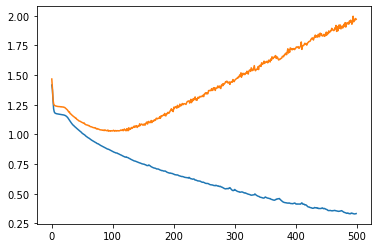

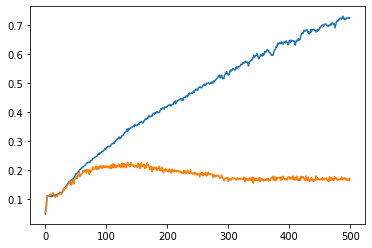

In [ ]:
plot_history(history)